# <font color="red">Conditions Prediction with Naive Bayes MultinomialNB Classifier</font>

# Import Library

In [1]:
# Data manipulation and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
import json

# Preprocessing
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier

import sys
sys.path.append('../../') # Uncomment this line if running locally
# sys.path.append('/kaggle/input/weatherdata') # Uncomment this line if running on Kaggle
from historyManagement import *

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Datasets Import

In [2]:
# Load the weather dataset for visibility prediction
weather_data = pd.read_csv('../../FinalDatasets/finalDataset.csv') # Uncomment this line if running locally
# weather_data = pd.read_csv('/kaggle/input/weatherdata/finalDataset.csv') # Uncomment this line if running on Kaggl
weather_data['DateTime'] = pd.to_datetime(weather_data['DateTime'])
weather_data.head()

,DateTime,Year,Month,Day,Hour,DaySegments,DaySegments_Afternoon,DaySegments_Early Morning,DaySegments_Evening,DaySegments_Late Night,...,WindDir,SeaLevelPressure,CloudCover,UVIndex,SevereRisk,Visibility,SolarRadiation,SolarEnergy,Conditions,Icon
0,2023-01-01 00:00:00,2023,1,1,0,Late Night,0,0,0,1,...,0.49,1018.68,0.03,0.0,10.0,2.76,0.0,0.0,Clear,clear-night
1,2023-01-01 01:00:00,2023,1,1,1,Late Night,0,0,0,1,...,0.54,1018.03,0.11,0.0,10.0,1.75,0.0,0.0,Clear,clear-night
2,2023-01-01 02:00:00,2023,1,1,2,Late Night,0,0,0,1,...,30.51,1017.56,0.03,0.0,10.0,1.75,0.0,0.0,Clear,clear-night
3,2023-01-01 03:00:00,2023,1,1,3,Late Night,0,0,0,1,...,49.23,1018.05,0.00,0.0,10.0,2.28,0.0,0.0,Clear,clear-night
4,2023-01-01 04:00:00,2023,1,1,4,Late Night,0,0,0,1,...,49.90,1018.00,86.17,0.0,10.0,1.27,0.0,0.0,Partially cloudy,fog


In [3]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14616 entries, 0 to 14615
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   14616 non-null  datetime64[ns]
 1   Year                       14616 non-null  int64         
 2   Month                      14616 non-null  int64         
 3   Day                        14616 non-null  int64         
 4   Hour                       14616 non-null  int64         
 5   DaySegments                14616 non-null  object        
 6   DaySegments_Afternoon      14616 non-null  int64         
 7   DaySegments_Early Morning  14616 non-null  int64         
 8   DaySegments_Evening        14616 non-null  int64         
 9   DaySegments_Late Night     14616 non-null  int64         
 10  DaySegments_Midday         14616 non-null  int64         
 11  DaySegments_Morning        14616 non-null  int64         
 12  DayS

In [4]:
weather_data.describe()

,DateTime,Year,Month,Day,Hour,DaySegments_Afternoon,DaySegments_Early Morning,DaySegments_Evening,DaySegments_Late Night,DaySegments_Midday,...,Windgust,WindSpeed,WindDir,SeaLevelPressure,CloudCover,UVIndex,SevereRisk,Visibility,SolarRadiation,SolarEnergy
count,14616,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,...,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000
mean,2023-11-01 11:30:00,2023.400657,5.720854,15.735632,11.500000,0.131294,0.060550,0.098043,0.249726,0.116585,...,17.068560,8.090783,159.739178,1008.265012,53.579923,2.263555,16.504787,4.368134,227.640683,0.819217
min,2023-01-01 00:00:00,2023.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.660000,0.000000,0.000000,982.420000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
25%,2023-06-02 05:45:00,2023.000000,3.000000,8.000000,5.750000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.170000,2.870000,80.965000,1003.277500,26.670000,0.000000,10.000000,3.990000,0.000000,0.000000
50%,2023-11-01 11:30:00,2023.000000,6.000000,16.000000,11.500000,0.000000,0.000000,0.000000,0.000000,0.000000,...,14.645000,7.670000,163.790000,1007.970000,51.540000,0.000000,10.000000,4.650000,10.665000,0.010000
75%,2024-04-01 17:15:00,2024.000000,8.000000,23.000000,17.250000,0.000000,0.000000,0.000000,0.000000,0.000000,...,23.410000,11.750000,241.402500,1013.400000,87.790000,4.740000,12.580000,4.650000,459.745000,1.660000
max,2024-08-31 23:00:00,2024.000000,12.000000,31.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,84.120000,71.970000,360.000000,1022.060000,100.000000,10.000000,97.740000,24.100000,1026.650000,3.700000
std,NaN,0.490048,3.195073,8.803610,6.922423,0.337734,0.238511,0.297383,0.432869,0.320936,...,10.195911,6.250203,104.422027,6.010683,35.166637,3.083074,15.031827,1.376994,307.219387,1.106444


# Data Split

In [5]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
for train_idx, test_idx in sss.split(weather_data, weather_data['Conditions']):
    weather_data_train = weather_data.iloc[train_idx]
    weather_data_test = weather_data.iloc[test_idx]

In [6]:
# Show the count of each unique class in Conditions
class_counts = weather_data['Conditions'].value_counts().reset_index()
class_counts.columns = ['Conditions', 'Count']

print("Distribution of data based on Conditions:")
print(class_counts)

Distribution of data based on Conditions:
               Conditions  Count
0        Partially cloudy   7785
1                   Clear   3316
2  Rain, Partially cloudy   2118
3          Rain, Overcast    746
4                Overcast    629
5                    Rain     22


In [7]:
print("Distribution of Conditions in Training Set:")
print(weather_data_train['Conditions'].value_counts())

print("\nDistribution of Conditions in Test Set:")
print(weather_data_test['Conditions'].value_counts())

Distribution of Conditions in Training Set:
Conditions
Partially cloudy          6227
Clear                     2653
Rain, Partially cloudy    1694
Rain, Overcast             597
Overcast                   503
Rain                        18
Name: count, dtype: int64

Distribution of Conditions in Test Set:
Conditions
Partially cloudy          1558
Clear                      663
Rain, Partially cloudy     424
Rain, Overcast             149
Overcast                   126
Rain                         4
Name: count, dtype: int64


# Some Reused Parameters

In [8]:
grid_param = {
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
}

In [9]:
number_of_model_for_randomized_grid = 50
model_name_for_saving = "Naive Bayes MultinomialNB"
target_name_for_saving = "Conditions"
number_of_model_for_bagging = 100

# All Features

In [10]:
X_train_raw = weather_data_train.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon']) # Target variable
y_train = weather_data_train['Conditions']

In [11]:
X_test_raw = weather_data_test.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon']) # Target variable
y_test = weather_data_test['Conditions']

In [12]:
feature_columns = [col for col in X_train_raw.columns]
feature_columns_for_saving = ','.join(feature_columns)

In [13]:
print("X_train: ", len(X_train_raw))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test_raw))
print("y_test: ", len(y_test))

X_train:  11692
y_train:  11692

X_test:  2924
y_test:  2924


## MinMax Scaler

In [14]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [15]:
X_train

array([[0.81818182, 0.46666667, 0.69565217, ..., 0.4906    , 0.319     ,
        0.08950813],
       [0.27272727, 0.16666667, 0.86956522, ..., 0.5161    , 0.        ,
        0.68439941],
       [1.        , 0.3       , 0.        , ..., 0.3604    , 0.        ,
        0.07388643],
       ...,
       [0.27272727, 0.83333333, 0.        , ..., 0.2311    , 0.        ,
        0.07388643],
       [0.18181818, 0.53333333, 0.34782609, ..., 0.8811    , 0.197     ,
        0.0204771 ],
       [0.18181818, 0.8       , 0.65217391, ..., 0.8155    , 0.542     ,
        0.07388643]], shape=(11692, 27))

In [16]:
X_test

array([[0.18181818, 0.4       , 0.52173913, ..., 0.2298    , 0.9       ,
        0.07388643],
       [0.72727273, 0.06666667, 1.        , ..., 0.8872    , 0.        ,
        0.08074731],
       [0.45454545, 0.56666667, 0.73913043, ..., 0.8894    , 0.206     ,
        0.58465273],
       ...,
       [0.27272727, 0.76666667, 0.82608696, ..., 0.8816    , 0.        ,
        0.06195905],
       [0.72727273, 0.43333333, 0.86956522, ..., 0.8825    , 0.        ,
        0.09436352],
       [0.27272727, 0.66666667, 0.26086957, ..., 0.4901    , 0.        ,
        0.99324467]], shape=(2924, 27))

### Default Parameters

In [17]:
training_model = MultinomialNB()
training_model

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [18]:
%%time
training_model.fit(X_train, y_train)

CPU times: total: 15.6 ms
Wall time: 20.3 ms


,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [19]:
y_pred = training_model.predict(X_test)
y_pred

array(['Partially cloudy', 'Partially cloudy', 'Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      shape=(2924,), dtype='<U22')

In [20]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [21]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [22]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.7845
Precision: 0.7342
Recall:    0.7845
F1-Score:  0.7319


In [23]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.96      0.49      0.65       663
              Overcast       0.00      0.00      0.00       126
      Partially cloudy       0.77      0.99      0.87      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.00      0.00      0.00       149
Rain, Partially cloudy       0.74      1.00      0.85       424

              accuracy                           0.78      2924
             macro avg       0.41      0.41      0.39      2924
          weighted avg       0.73      0.78      0.73      2924



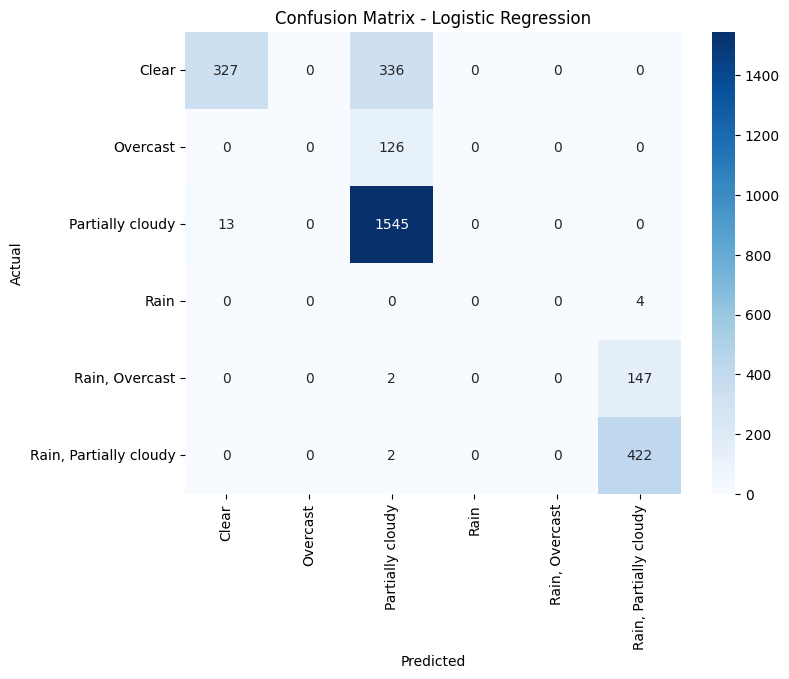

In [24]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [25]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [26]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [27]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9824
Overcast : 0.8714
Partially cloudy : 0.9336
Rain     : 0.8902
Rain, Overcast : 0.9502
Rain, Partially cloudy : 0.9781
Micro-avg : 0.9701


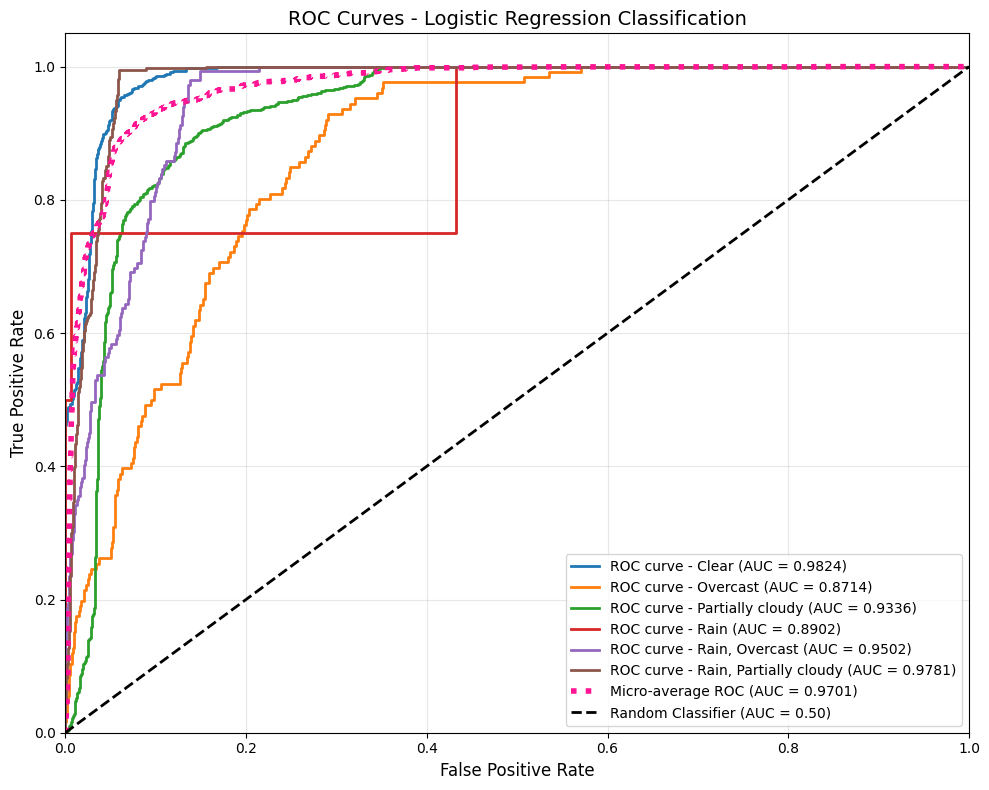

In [28]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9492
One-vs-One (Weighted)  : 0.9216
Micro-average          : 0.9701


In [30]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.784542, F1: 0.731921, AUC (micro-avg): 0.970092
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Tuning with Grid Search

In [31]:
grid_search = RandomizedSearchCV(
    MultinomialNB(), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

,estimator,MultinomialNB()
,param_distributions,"{'alpha': [0.1, 0.2, ...]}"
,n_iter,50
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [32]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
CPU times: total: 250 ms
Wall time: 4.45 s


,estimator,MultinomialNB()
,param_distributions,"{'alpha': [0.1, 0.2, ...]}"
,n_iter,50
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [33]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'alpha': 0.9}
Best Cross-Validation Score: 0.7404896756902646


In [34]:
y_pred_grid = best_grid_model.predict(X_test)

In [35]:
y_pred_grid

array(['Partially cloudy', 'Partially cloudy', 'Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      shape=(2924,), dtype='<U22')

In [36]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [37]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [38]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.7845
Precision: 0.7342
Recall:    0.7845
F1-Score:  0.7319


In [39]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.96      0.49      0.65       663
              Overcast       0.00      0.00      0.00       126
      Partially cloudy       0.77      0.99      0.87      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.00      0.00      0.00       149
Rain, Partially cloudy       0.74      1.00      0.85       424

              accuracy                           0.78      2924
             macro avg       0.41      0.41      0.39      2924
          weighted avg       0.73      0.78      0.73      2924



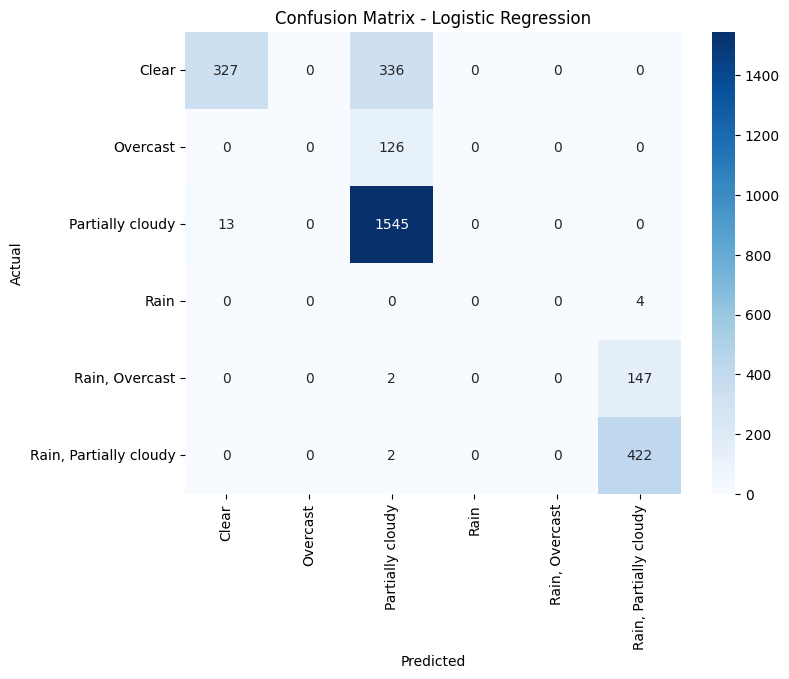

In [40]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [41]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [42]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [43]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9824
Overcast : 0.8714
Partially cloudy : 0.9336
Rain     : 0.8878
Rain, Overcast : 0.9502
Rain, Partially cloudy : 0.9781
Micro-avg : 0.9701


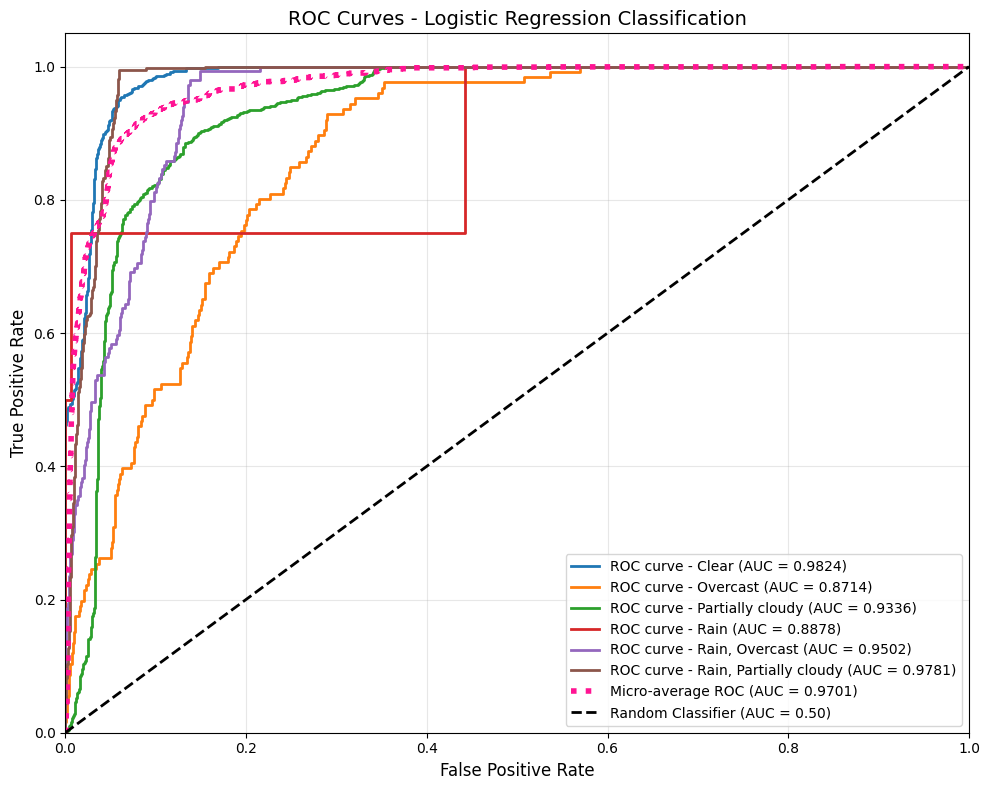

In [44]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [45]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9492
One-vs-One (Weighted)  : 0.9214
Micro-average          : 0.9701


In [46]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.784542, F1: 0.731921, AUC (micro-avg): 0.970096
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Ensambling with Bagging

In [47]:
base_model = MultinomialNB()
base_model

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [48]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

,estimator,MultinomialNB()
,n_estimators,100
,max_samples,1.0
,max_features,0.8
,bootstrap,True
,bootstrap_features,True
,oob_score,False
,warm_start,False
,n_jobs,-1
,random_state,42
,verbose,1


In [49]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


CPU times: total: 31.2 ms
Wall time: 416 ms


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


,estimator,MultinomialNB()
,n_estimators,100
,max_samples,1.0
,max_features,0.8
,bootstrap,True
,bootstrap_features,True
,oob_score,False
,warm_start,False
,n_jobs,-1
,random_state,42
,verbose,1


In [50]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [51]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [52]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.7821
Precision: 0.7375
Recall:    0.7821
F1-Score:  0.7286


In [53]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.99      0.48      0.64       663
              Overcast       0.00      0.00      0.00       126
      Partially cloudy       0.76      1.00      0.86      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.00      0.00      0.00       149
Rain, Partially cloudy       0.74      0.98      0.84       424

              accuracy                           0.78      2924
             macro avg       0.41      0.41      0.39      2924
          weighted avg       0.74      0.78      0.73      2924



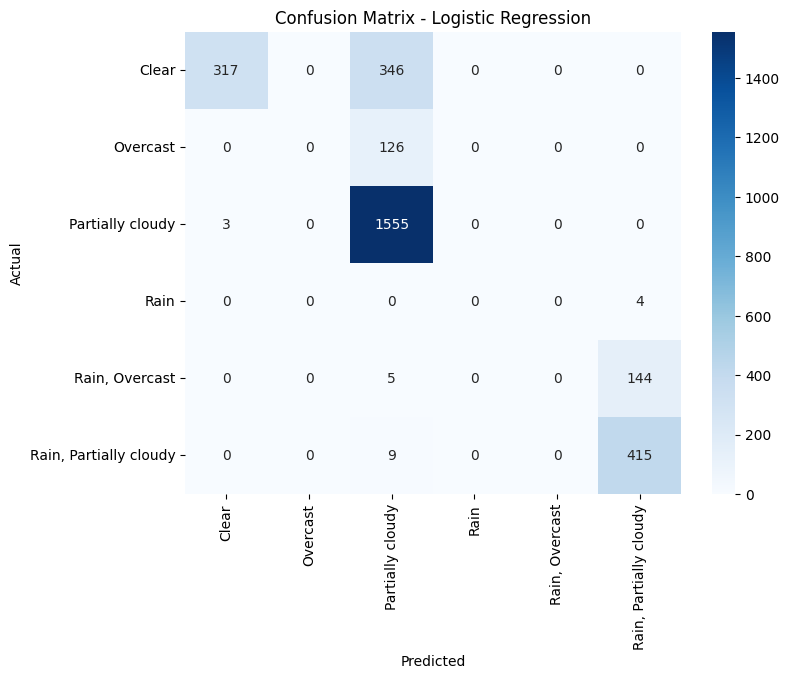

In [54]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [55]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [56]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [57]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9861
Overcast : 0.8705
Partially cloudy : 0.9488
Rain     : 0.9229
Rain, Overcast : 0.9503
Rain, Partially cloudy : 0.9738
Micro-avg : 0.9600


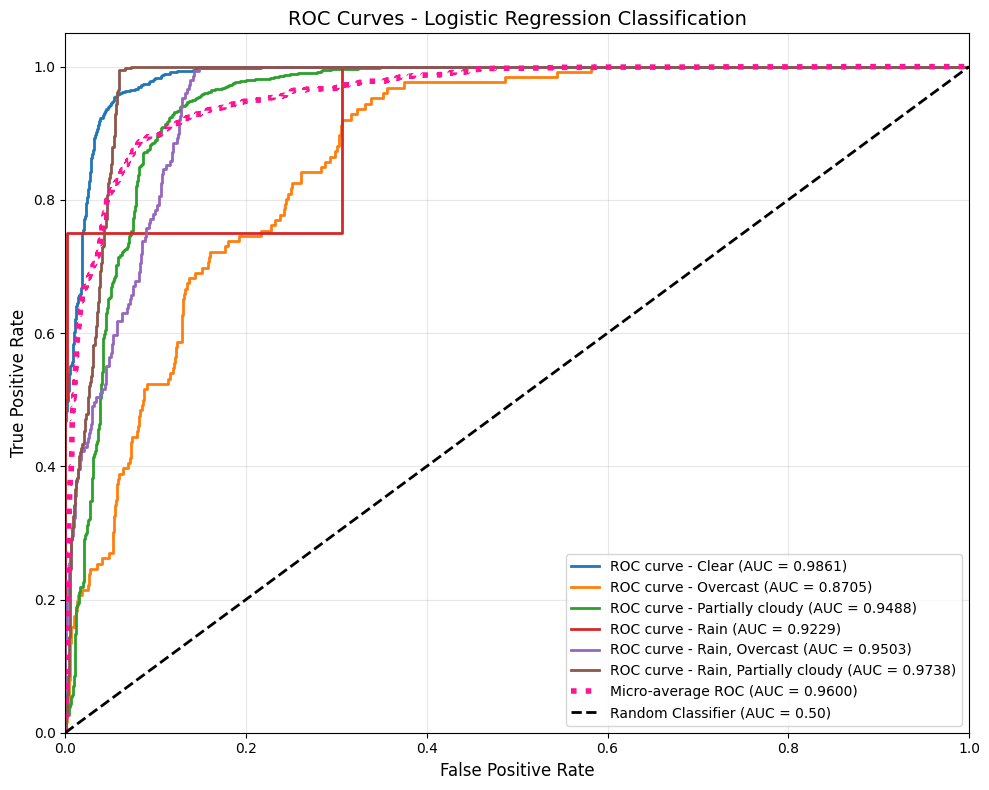

In [58]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [59]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9576
One-vs-One (Weighted)  : 0.9305
Micro-average          : 0.9600


In [60]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.782148, F1: 0.728618, AUC (micro-avg): 0.959967
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


# Selected Features

In [61]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14616 entries, 0 to 14615
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   14616 non-null  datetime64[ns]
 1   Year                       14616 non-null  int64         
 2   Month                      14616 non-null  int64         
 3   Day                        14616 non-null  int64         
 4   Hour                       14616 non-null  int64         
 5   DaySegments                14616 non-null  object        
 6   DaySegments_Afternoon      14616 non-null  int64         
 7   DaySegments_Early Morning  14616 non-null  int64         
 8   DaySegments_Evening        14616 non-null  int64         
 9   DaySegments_Late Night     14616 non-null  int64         
 10  DaySegments_Midday         14616 non-null  int64         
 11  DaySegments_Morning        14616 non-null  int64         
 12  DayS

## Run Again

In [62]:
X_train_raw = weather_data_train.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_train = weather_data_train['Conditions']

In [63]:
X_test_raw = weather_data_test.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_test = weather_data_test['Conditions']

In [64]:
feature_columns = [col for col in X_train_raw.columns]
feature_columns_for_saving = ','.join(feature_columns)

In [65]:
print("X_train: ", len(X_train_raw))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test_raw))
print("y_test: ", len(y_test))

X_train:  11692
y_train:  11692

X_test:  2924
y_test:  2924


### MinMax Scaler

In [66]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [67]:
X_train

array([[0.81818182, 0.69565217, 1.        , ..., 0.4906    , 0.319     ,
        0.08950813],
       [0.27272727, 0.86956522, 0.        , ..., 0.5161    , 0.        ,
        0.68439941],
       [1.        , 0.        , 0.        , ..., 0.3604    , 0.        ,
        0.07388643],
       ...,
       [0.27272727, 0.        , 0.        , ..., 0.2311    , 0.        ,
        0.07388643],
       [0.18181818, 0.34782609, 0.        , ..., 0.8811    , 0.197     ,
        0.0204771 ],
       [0.18181818, 0.65217391, 1.        , ..., 0.8155    , 0.542     ,
        0.07388643]], shape=(11692, 23))

In [68]:
X_test

array([[0.18181818, 0.52173913, 0.        , ..., 0.2298    , 0.9       ,
        0.07388643],
       [0.72727273, 1.        , 0.        , ..., 0.8872    , 0.        ,
        0.08074731],
       [0.45454545, 0.73913043, 1.        , ..., 0.8894    , 0.206     ,
        0.58465273],
       ...,
       [0.27272727, 0.82608696, 0.        , ..., 0.8816    , 0.        ,
        0.06195905],
       [0.72727273, 0.86956522, 0.        , ..., 0.8825    , 0.        ,
        0.09436352],
       [0.27272727, 0.26086957, 0.        , ..., 0.4901    , 0.        ,
        0.99324467]], shape=(2924, 23))

#### Default Parameters

In [69]:
training_model = MultinomialNB()
training_model

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [70]:
%%time
training_model.fit(X_train, y_train)

CPU times: total: 15.6 ms
Wall time: 16.7 ms


,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [71]:
y_pred = training_model.predict(X_test)
y_pred

array(['Partially cloudy', 'Partially cloudy', 'Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      shape=(2924,), dtype='<U22')

In [72]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [73]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [74]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.7863
Precision: 0.7393
Recall:    0.7863
F1-Score:  0.7332


In [75]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.98      0.49      0.65       663
              Overcast       0.00      0.00      0.00       126
      Partially cloudy       0.77      1.00      0.87      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.00      0.00      0.00       149
Rain, Partially cloudy       0.74      1.00      0.85       424

              accuracy                           0.79      2924
             macro avg       0.41      0.41      0.39      2924
          weighted avg       0.74      0.79      0.73      2924



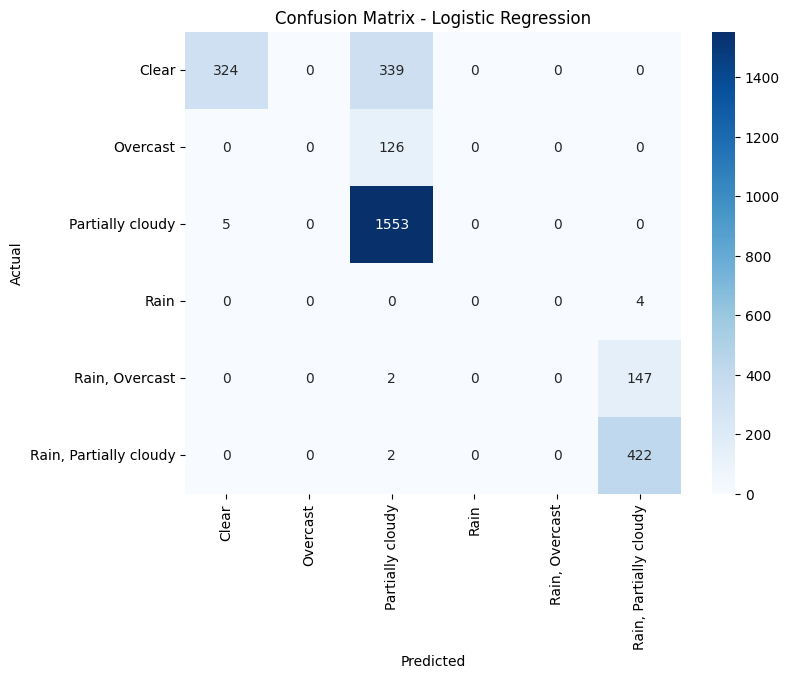

In [76]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [77]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [78]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [79]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9836
Overcast : 0.8707
Partially cloudy : 0.9349
Rain     : 0.8918
Rain, Overcast : 0.9490
Rain, Partially cloudy : 0.9775
Micro-avg : 0.9699


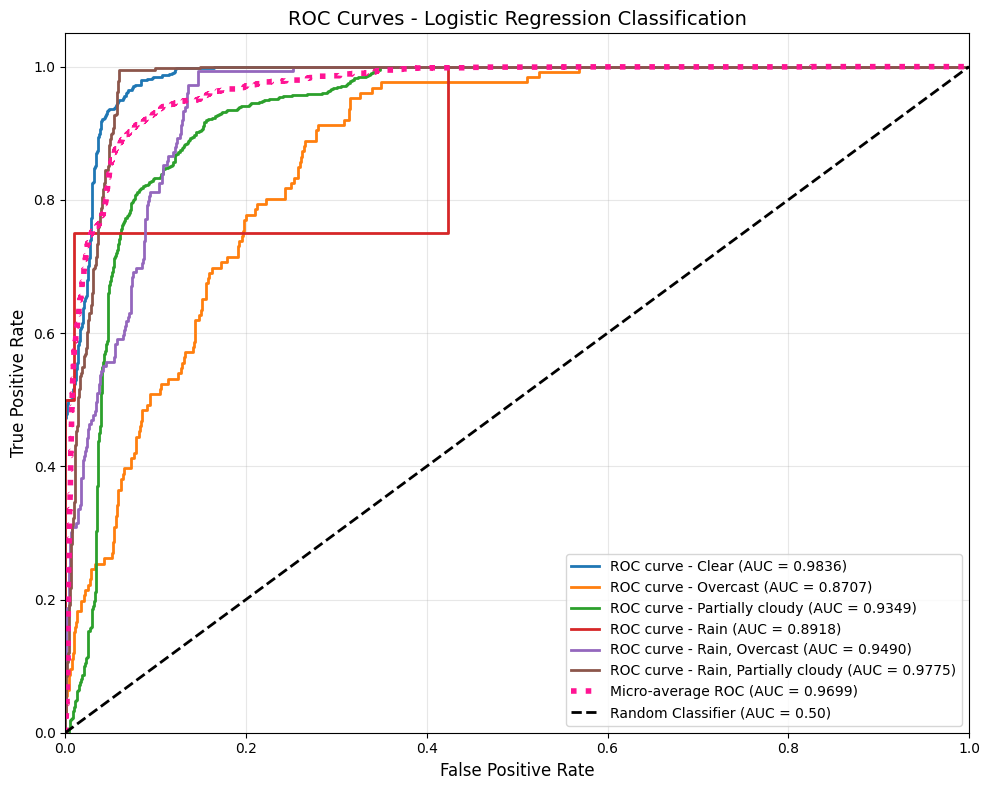

In [80]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [81]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9500
One-vs-One (Weighted)  : 0.9218
Micro-average          : 0.9699


In [82]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.784542 → 0.786252
   F1-Score: 0.731921 → 0.733153
   AUC (micro-avg): 0.970092 → 0.969923
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Tuning with Grid Search

In [83]:
grid_search = RandomizedSearchCV(
    MultinomialNB(), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

,estimator,MultinomialNB()
,param_distributions,"{'alpha': [0.1, 0.2, ...]}"
,n_iter,50
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [84]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
CPU times: total: 156 ms
Wall time: 1.05 s


,estimator,MultinomialNB()
,param_distributions,"{'alpha': [0.1, 0.2, ...]}"
,n_iter,50
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [85]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'alpha': 0.5}
Best Cross-Validation Score: 0.7399995697925623


In [86]:
y_pred_grid = best_grid_model.predict(X_test)

In [87]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [88]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.7863
Precision: 0.7393
Recall:    0.7863
F1-Score:  0.7332


In [89]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.98      0.49      0.65       663
              Overcast       0.00      0.00      0.00       126
      Partially cloudy       0.77      1.00      0.87      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.00      0.00      0.00       149
Rain, Partially cloudy       0.74      1.00      0.85       424

              accuracy                           0.79      2924
             macro avg       0.41      0.41      0.39      2924
          weighted avg       0.74      0.79      0.73      2924



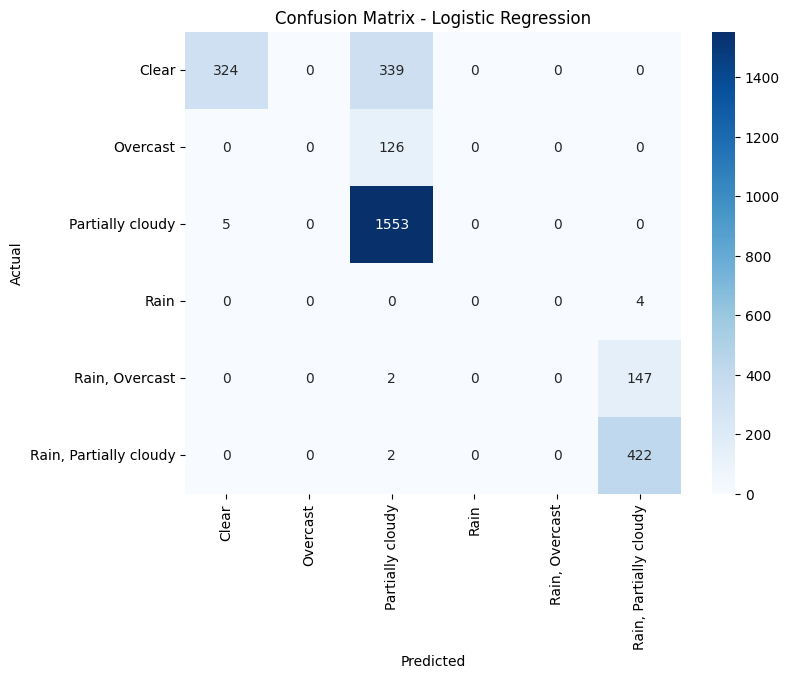

In [90]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [91]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [92]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [93]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9837
Overcast : 0.8705
Partially cloudy : 0.9349
Rain     : 0.8650
Rain, Overcast : 0.9489
Rain, Partially cloudy : 0.9775
Micro-avg : 0.9699


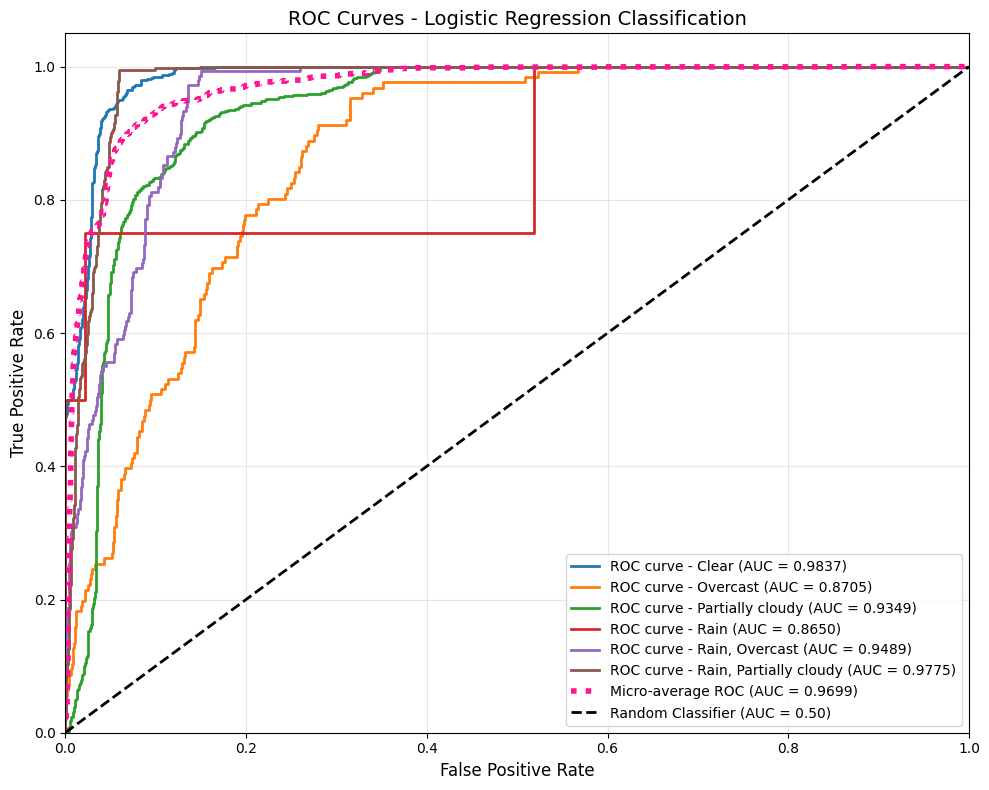

In [94]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [95]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9500
One-vs-One (Weighted)  : 0.9192
Micro-average          : 0.9699


In [96]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.784542 → 0.786252
   F1-Score: 0.731921 → 0.733153
   AUC (micro-avg): 0.970096 → 0.969938
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Ensambling with Bagging

In [97]:
base_model = MultinomialNB()
base_model

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [98]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

,estimator,MultinomialNB()
,n_estimators,100
,max_samples,1.0
,max_features,0.8
,bootstrap,True
,bootstrap_features,True
,oob_score,False
,warm_start,False
,n_jobs,-1
,random_state,42
,verbose,1


In [99]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


CPU times: total: 15.6 ms
Wall time: 261 ms


,estimator,MultinomialNB()
,n_estimators,100
,max_samples,1.0
,max_features,0.8
,bootstrap,True
,bootstrap_features,True
,oob_score,False
,warm_start,False
,n_jobs,-1
,random_state,42
,verbose,1


In [100]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [101]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [102]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.7815
Precision: 0.7391
Recall:    0.7815
F1-Score:  0.7266


In [103]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       1.00      0.46      0.63       663
              Overcast       0.00      0.00      0.00       126
      Partially cloudy       0.76      1.00      0.86      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.00      0.00      0.00       149
Rain, Partially cloudy       0.74      0.99      0.84       424

              accuracy                           0.78      2924
             macro avg       0.42      0.41      0.39      2924
          weighted avg       0.74      0.78      0.73      2924



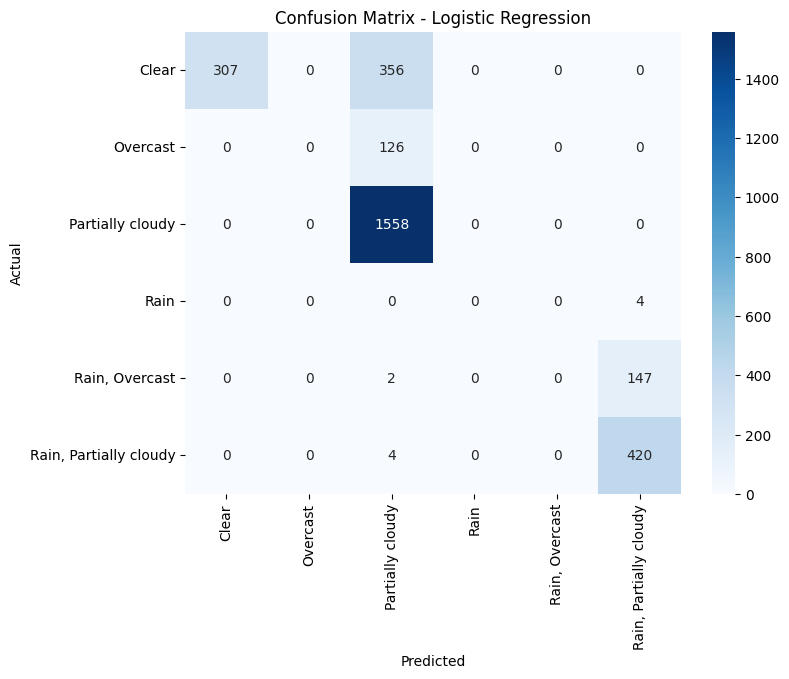

In [104]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [105]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [106]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [107]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9730
Overcast : 0.8527
Partially cloudy : 0.9420
Rain     : 0.9335
Rain, Overcast : 0.9480
Rain, Partially cloudy : 0.9733
Micro-avg : 0.9563


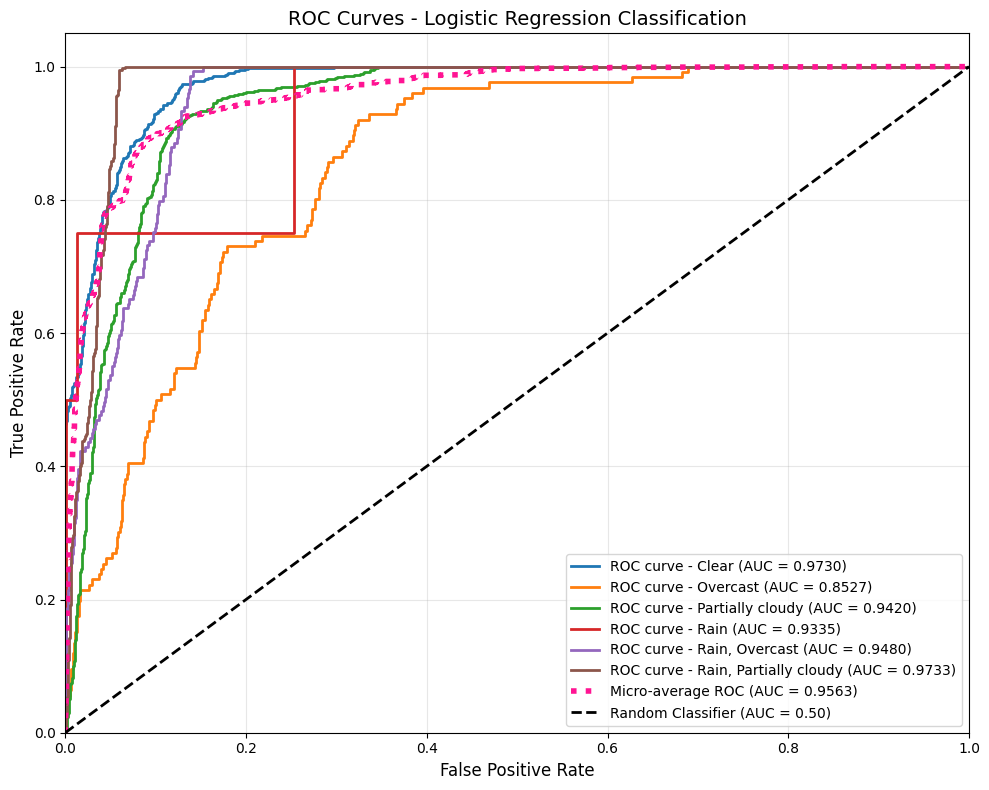

In [108]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [109]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9500
One-vs-One (Weighted)  : 0.9260
Micro-average          : 0.9563


In [110]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with same performance but fewer features!
   Accuracy: 0.782148 ≈ 0.781464 (similar)
   F1-Score: 0.728618 ≈ 0.726628 (similar)
   AUC (micro-avg): 0.959967 ≈ 0.956276
   Features: 27 → 23 (🎯 4 fewer features!)
💾 Registry updated: Model_Training_History/History_Classification.csv


# All Performance

In [111]:
show_model_history('classification', model_name=model_name_for_saving, target_column=target_name_for_saving)


📊 CLASSIFICATION Model Performance History
                            Model       Scaler     Target  Features Accuracy Precision   Recall F1-Score
        Naive Bayes MultinomialNB MinMaxScaler Conditions        23 0.786252  0.739334 0.786252 0.733153
   Naive Bayes MultinomialNB Grid MinMaxScaler Conditions        23 0.786252  0.739334 0.786252 0.733153
Naive Bayes MultinomialNB Bagging MinMaxScaler Conditions        23 0.781464  0.739148 0.781464 0.726628

📈 Total models shown: 3
🏆 Best F1-Score: 0.733153 (Naive Bayes MultinomialNB + MinMaxScaler for Conditions)


# <center><font size="50" color="red">Thank You</font></center>